In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install tensorflow
!pip install keras

     |████████████████████████████████| 462 kB 4.3 MB/s 


In [2]:
# Importing Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import tensorflow
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from tensorflow import keras
from keras import callbacks
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, Dense, LSTM, Dropout, GRU, Bidirectional
from tensorflow.keras.optimizers import SGD, Adam
import math
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [18]:
#Loading Data
data = pd.read_csv("/content/drive/MyDrive/AIConnect/Traffic_forecast/trainvalidtest.csv")
data = data.replace(-999, np.nan)

data.tail(5)

,날짜,시간,10,100,101,120,121,140,150,160,200,201,251,270,300,301,351,352,370,400,450,500,550,600,650,652,1000,1020,1040,1100,1200,1510,2510,3000,4510,5510,6000
3643,20200531,19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3644,20200531,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3645,20200531,21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3646,20200531,22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3647,20200531,23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [19]:
# DateTime 을 인덱스로 만들어 사용.
df = data.copy()
df.rename(columns = {'날짜' : 'DateTime'}, inplace = True)
df.rename(columns = {'시간' : 'Hour'}, inplace = True)
df['DateTime'] = df['DateTime'].astype(str)
df['DateTime'] = pd.to_datetime(df['DateTime'])
df['DateTime'] = df['DateTime'] + pd.to_timedelta(df['Hour'], unit='h')
df.drop('Hour', axis='columns', inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3648 entries, 0 to 3647
Data columns (total 36 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   DateTime  3648 non-null   datetime64[ns]
 1   10        3480 non-null   float64       
 2   100       3480 non-null   float64       
 3   101       3480 non-null   float64       
 4   120       3480 non-null   float64       
 5   121       3480 non-null   float64       
 6   140       3480 non-null   float64       
 7   150       3480 non-null   float64       
 8   160       3480 non-null   float64       
 9   200       3480 non-null   float64       
 10  201       3480 non-null   float64       
 11  251       3480 non-null   float64       
 12  270       3480 non-null   float64       
 13  300       3480 non-null   float64       
 14  301       3480 non-null   float64       
 15  351       3480 non-null   float64       
 16  352       3480 non-null   float64       
 17  370       3480

In [20]:
df_10 = df[['DateTime', '10']] # 10 번 도로가 가장 큰 교통량을 가지므로 일단 이것부터 조져보자

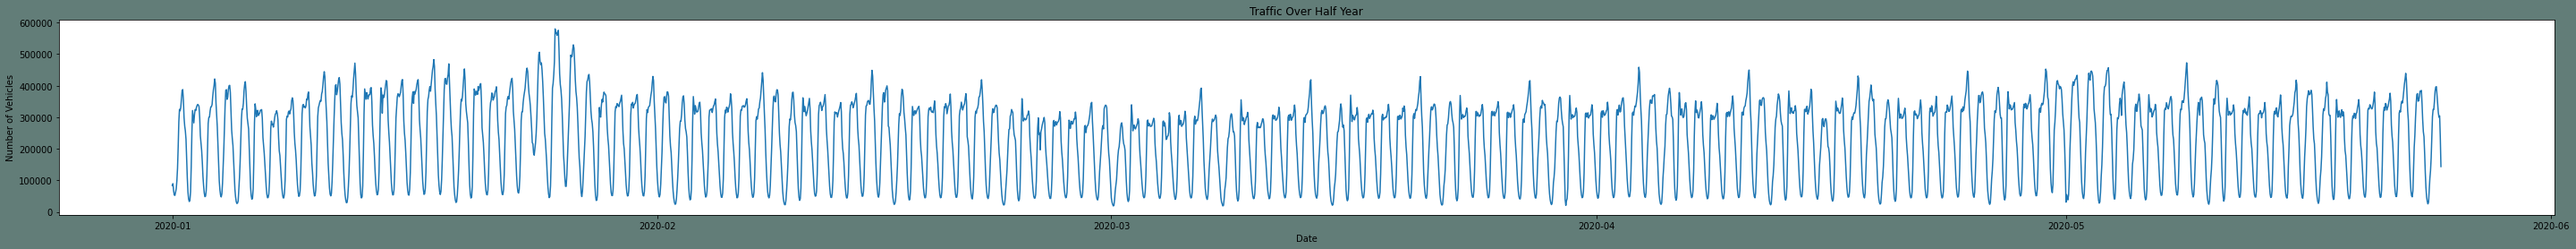

In [21]:
# 전체 데이터 시각화 . 클릭하면 커짐
plt.figure(figsize=(50, 4),facecolor="#627D78")
Time_series=sns.lineplot(x=df_10['DateTime'],y="10", data=df_10)
Time_series.set_title("Traffic Over Half Year")
Time_series.set_ylabel("Number of Vehicles")
Time_series.set_xlabel("Date")
plt.show()

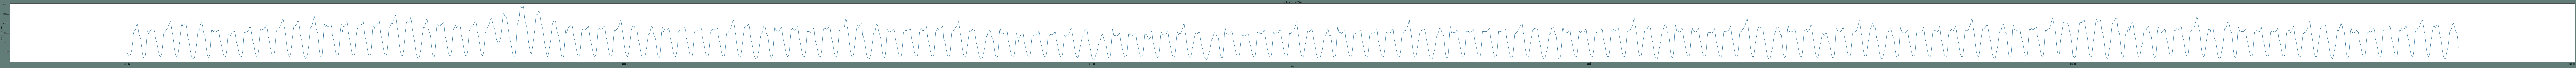

In [22]:
# 클릭하면 커짐
plt.figure(figsize= (300 ,7),facecolor="#627D78")
Time_series=sns.lineplot(x=df_10['DateTime'],y="10", data=df_10)
Time_series.set_title("Traffic Over Half Year")
Time_series.set_ylabel("Number of Vehicles")
Time_series.set_xlabel("Date")
plt.show()

In [ ]:
# 시각화를 위한 월, 일, 시간, 요일 column 추가

df_10["Month"]= df_10['DateTime'].dt.month
df_10["Date_no"]= df_10['DateTime'].dt.day
df_10["Hour"]= df_10['DateTime'].dt.hour
df_10["Day"]= df_10.DateTime.dt.strftime("%A")
df_10.head()

,DateTime,10,Month,Date_no,Hour,Day
0,2020-01-01 00:00:00,83247,1,1,0,Wednesday
1,2020-01-01 01:00:00,89309,1,1,1,Wednesday
2,2020-01-01 02:00:00,66611,1,1,2,Wednesday
3,2020-01-01 03:00:00,53290,1,1,3,Wednesday
4,2020-01-01 04:00:00,52095,1,1,4,Wednesday


In [ ]:
df_10.head(100)

,DateTime,10,Month,Date_no,Hour,Day
0,2020-01-01 00:00:00,83247,1,1,0,Wednesday
1,2020-01-01 01:00:00,89309,1,1,1,Wednesday
2,2020-01-01 02:00:00,66611,1,1,2,Wednesday
3,2020-01-01 03:00:00,53290,1,1,3,Wednesday
4,2020-01-01 04:00:00,52095,1,1,4,Wednesday
...,...,...,...,...,...,...
95,2020-01-04 23:00:00,113008,1,4,23,Saturday
96,2020-01-05 00:00:00,71491,1,5,0,Sunday
97,2020-01-05 01:00:00,47490,1,5,1,Sunday
98,2020-01-05 02:00:00,32479,1,5,2,Sunday


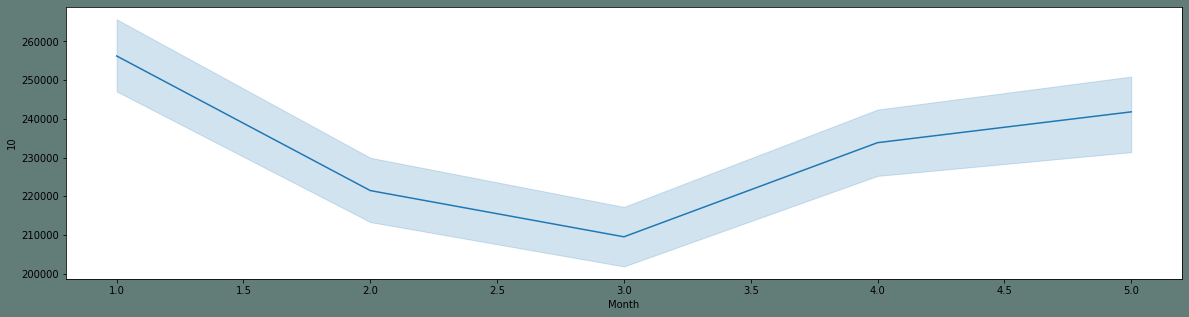

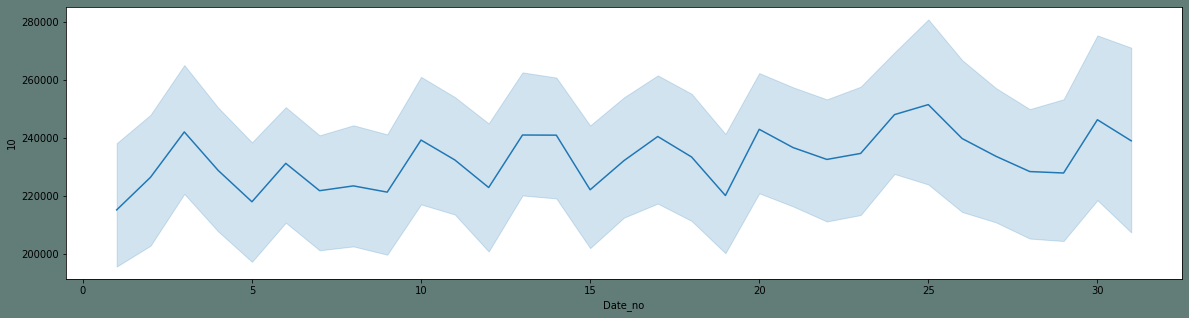

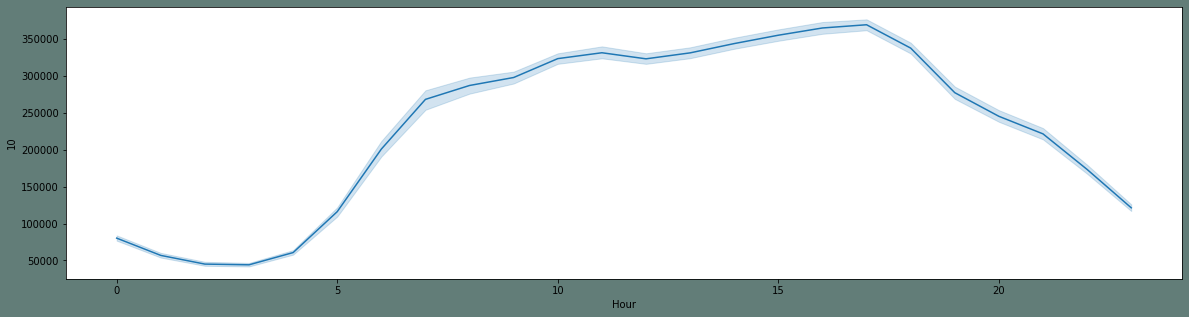

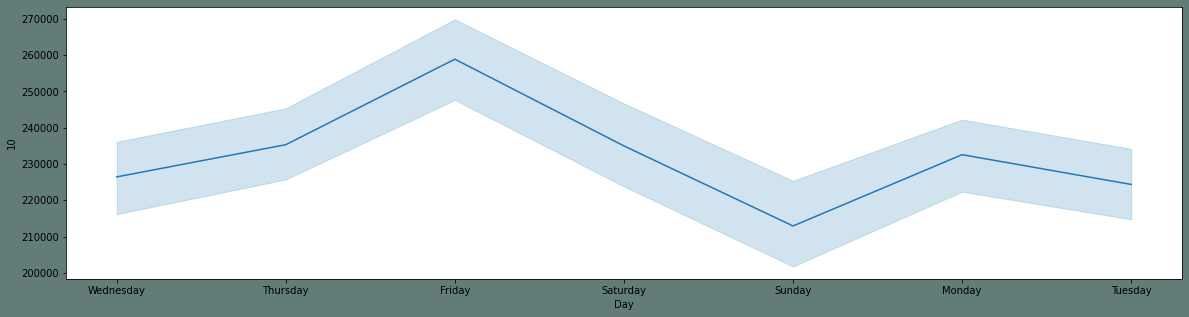

In [ ]:
# 월, 일, 시간, 요일 별 교통량 합산
new_features = ["Month", "Date_no", "Hour", "Day"]

for i in new_features:
    plt.figure(figsize=(20,5),facecolor="#627D78")
    ax=sns.lineplot(x=df_10[i],y="10",data=df_10)

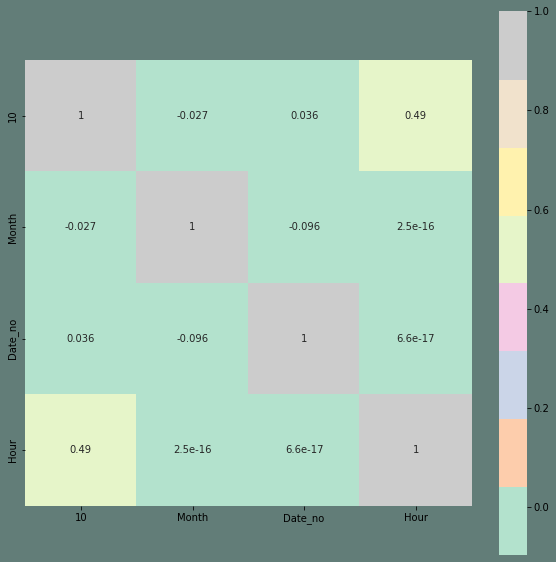

In [ ]:
# 교통량과 일, 월 , 시간 간의 연관성

corrmat = df_10.corr()
plt.subplots(figsize=(10, 10),facecolor="#627D78")
sns.heatmap(corrmat,cmap= "Pastel2",annot=True,square=True )

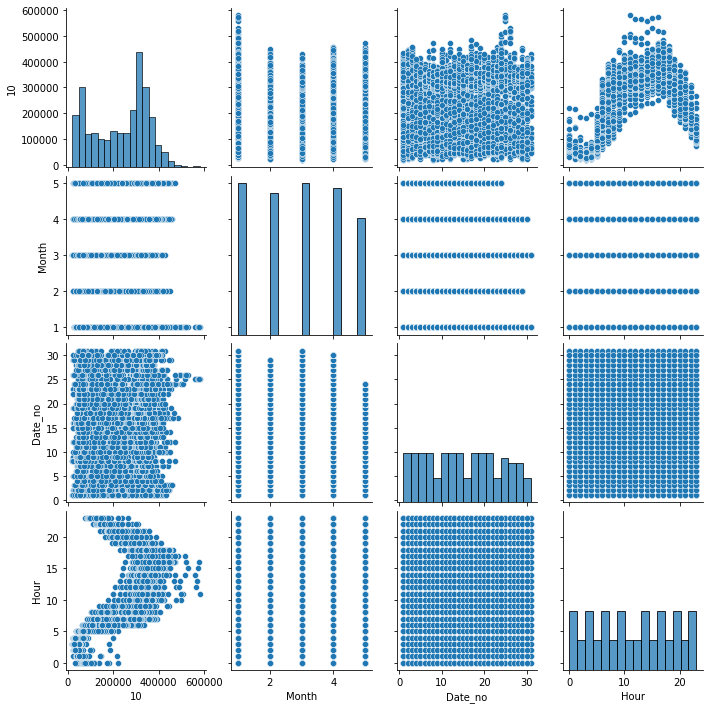

In [ ]:
sns.pairplot(data=df_10) # 뭔지 모르겠는데 그냥 해봄 ..

In [ ]:
df_10.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3480 entries, 0 to 3479
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   DateTime  3480 non-null   datetime64[ns]
 1   10        3480 non-null   int64         
 2   Month     3480 non-null   int64         
 3   Date_no   3480 non-null   int64         
 4   Hour      3480 non-null   int64         
 5   Day       3480 non-null   object        
dtypes: datetime64[ns](1), int64(4), object(1)
memory usage: 163.2+ KB


In [ ]:
# 월, 일, 시간, 요일 카테고리 변수로 변경.
df_10['Month'] = df_10['Month'].astype("category")
df_10['Date_no'] = df_10['Date_no'].astype("category")
df_10['Hour'] = df_10['Hour'].astype("category")
df_10['Day'] = df_10['Day'].astype("category")

In [ ]:
df_10.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3480 entries, 0 to 3479
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   DateTime  3480 non-null   datetime64[ns]
 1   10        3480 non-null   int64         
 2   Month     3480 non-null   category      
 3   Date_no   3480 non-null   category      
 4   Hour      3480 non-null   category      
 5   Day       3480 non-null   category      
dtypes: category(4), datetime64[ns](1), int64(1)
memory usage: 70.7 KB


In [ ]:
#Function to plot comparitive plots of dataframes
def Sub_Plots4(df_1, title):
    fig, axes = plt.subplots(4, 1, figsize=(15, 8),facecolor="#627D78", sharey=True)
    fig.suptitle(title)
    #J1
    pl_1=sns.lineplot(ax=axes[0],data=df_1)
    #pl_1=plt.ylabel()
    axes[0].set(ylabel ="road 10")

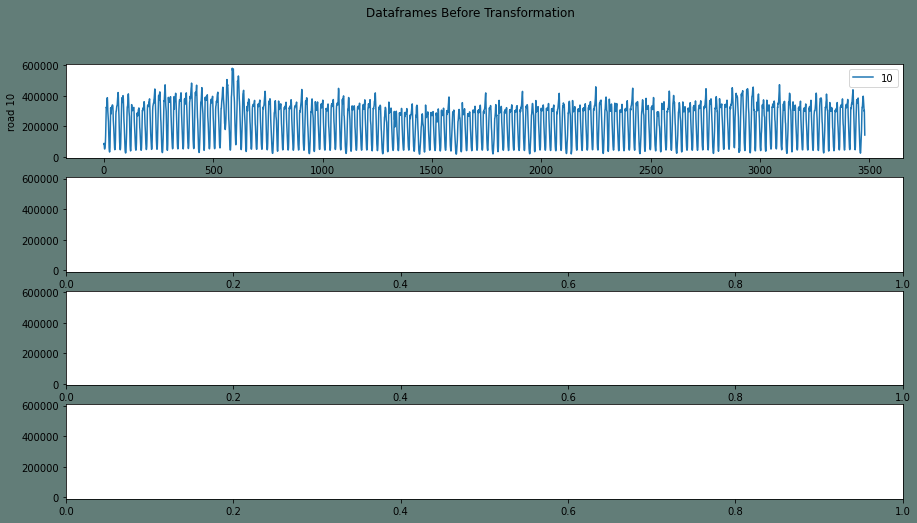

In [ ]:
Sub_Plots4(df_10, 'Dataframes Before Transformation')

In [ ]:
# Normalize Function
def Normalize(df,col):
    average = df[col].mean()
    stdev = df[col].std()
    df_normalized = (df[col] - average) / stdev
    df_normalized = df_normalized.to_frame()
    return df_normalized, average, stdev

# Differencing Function
def Difference(df,col, interval):
    diff = []
    for i in range(interval, len(df)):
        value = df[col][i] - df[col][i - interval] # 일주일 간격으로 각 차를 구하면 계절성이 제거됨.
        diff.append(value)
    return diff

In [ ]:
#Normalizing and Differencing to make the series stationary 
df_N1, av_J1, std_J1 = Normalize(df_10, "10")
Diff_1 = Difference(df_N1, col="10", interval=(24*7)) #taking a week's diffrence
df_N1 = df_N1[24*7:] # 첫주를 바탕으로 예측해 나가므로 첫주를 제거 해줌 (?)
df_N1.columns = ["Norm"]
df_N1["Diff"]= Diff_1

In [ ]:
df_N1 = df_N1.replace(np.nan, 0)
df_N1

,Norm,Diff
168,-1.282020,-0.055719
169,-1.454396,-0.277980
170,-1.546241,-0.183041
171,-1.547040,-0.074219
172,-1.426343,0.056312
...,...,...
3475,0.674457,0.020565
3476,0.557398,-0.044051
3477,0.591540,-0.015290
3478,0.036905,-0.005727


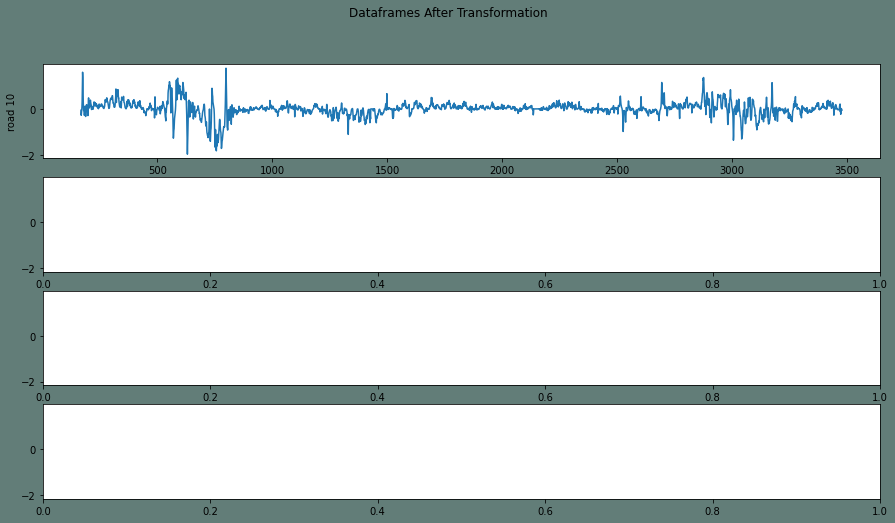

In [ ]:
Sub_Plots4(df_N1.Diff, "Dataframes After Transformation")

In [ ]:
#Stationary Check for the time series Augmented Dickey Fuller test
def Stationary_check(df):
    check = adfuller(df.dropna())
    print(f"ADF Statistic: {check[0]}")
    print(f"p-value: {check[1]}")
    print("Critical Values:")
    for key, value in check[4].items():
        print('\t%s: %.3f' % (key, value))
    if check[0] > check[4]["1%"]:
        print("Time Series is Non-Stationary")
    else:
        print("Time Series is Stationary") 
  

#Checking if the series is stationary

List_df_ND = [ df_N1["Diff"] ] 
print("Checking the transformed series for stationarity:")
for i in List_df_ND:
    print("\n")
    Stationary_check(i)

Checking the transformed series for stationarity:


ADF Statistic: -6.263178911846649
p-value: 4.174946969885084e-08
Critical Values:
	1%: -3.432
	5%: -2.862
	10%: -2.567
Time Series is Stationary


In [ ]:
#Differencing created some NA values as we took a weeks data into consideration while difrencing
df_J1 = df_N1["Diff"]
df_J1 = df_J1.to_frame()

In [ ]:
df_J1

,Diff
168,-0.055719
169,-0.277980
170,-0.183041
171,-0.074219
172,0.056312
...,...
3475,0.020565
3476,-0.044051
3477,-0.015290
3478,-0.005727


In [ ]:
#Splitting the dataset
def Split_data(df):
    training_size = int(len(df)*0.90)   # train data size
    data_len = len(df)
    train, test = df[0:training_size],df[training_size:data_len] 
    train, test = train.values.reshape(-1, 1), test.values.reshape(-1, 1)
    return train, test


#Splitting the training and test datasets 
J1_train, J1_test = Split_data(df_J1)

In [ ]:
J1_train.shape

(2980, 1)

In [ ]:
J1_test.shape

(332, 1)

In [ ]:
#Target and Feature
def TnF(df):
    end_len = len(df)
    X = []
    y = []
    steps = 32
    for i in range(steps, end_len):
        X.append(df[i - steps:i, 0])
        y.append(df[i, 0])
    X, y = np.array(X), np.array(y)
    return X ,y


In [ ]:
 #fixing the shape of X_test and X_train
def FeatureFixShape(train, test):
    train = np.reshape(train, (train.shape[0], train.shape[1], 1))
    test = np.reshape(test, (test.shape[0],test.shape[1],1))
    return train, test

#Assigning features and target 
X_trainJ1, y_trainJ1 = TnF(J1_train)
X_testJ1, y_testJ1 = TnF(J1_test)
X_trainJ1, X_testJ1 = FeatureFixShape(X_trainJ1, X_testJ1)

In [ ]:
from keras.utils.generic_utils import get_custom_objects
from keras import backend as K
from keras.layers import Activation

def swish(x, beta = 1):
    return (x * K.sigmoid(beta * x))

get_custom_objects().update({'swish': Activation(swish)})

In [ ]:
#Model for the prediction
def GRU_model(X_Train, y_Train, X_Test):
    early_stopping = callbacks.EarlyStopping(min_delta=0.001,patience=10, restore_best_weights=True) 
    #callback delta 0.01 may interrupt the learning, could eliminate this step, but meh!
    
    #The GRU model 
    model = Sequential()
    model.add(GRU(units=150, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh')) # swish ,  relu
    model.add(Dropout(0.2))
    model.add(GRU(units=150, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=50, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(GRU(units=50, return_sequences=True, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    #model.add(GRU(units=50, return_sequences=True,  input_shape=(X_Train.shape[1],1),activation='tanh'))
    #model.add(Dropout(0.2))
    model.add(GRU(units=50, input_shape=(X_Train.shape[1],1), activation='tanh'))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    #Compiling the model
    model.compile(optimizer=Adam(learning_rate=0.0001),loss='mean_squared_error')
    # model.fit 이 함수에 내장되어 있어 test dataset  의 Nan값을 채울 수가 없다.
    model.fit(X_Train,y_Train, epochs=100, batch_size=150,callbacks=[early_stopping]) 
    pred_GRU= model.predict(X_Test)
    return pred_GRU

#To calculate the root mean squred error in predictions
def RMSE_Value(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))
    return rmse

#To plot the comparitive plot of targets and predictions
def PredictionsPlot(test,predicted,m):
    plt.figure(figsize=(12,5),facecolor="#627D78")
    plt.plot(test, color='darkorange',label="True Value",alpha=0.5 )
    plt.plot(predicted, color="#627D78",label="Predicted Values")
    plt.title("GRU Traffic Prediction Vs True values")
    plt.xlabel("DateTime")
    plt.ylabel("Number of Vehicles")
    plt.legend()
    plt.show()

In [ ]:
#Predictions For First Junction
PredJ1 = GRU_model(X_trainJ1,y_trainJ1,X_testJ1)

Epoch 1/100
20/20 [==============================] - 7s 19ms/step - loss: 0.0884
Epoch 2/100
20/20 [==============================] - 0s 13ms/step - loss: 0.0749
Epoch 3/100
20/20 [==============================] - 0s 13ms/step - loss: 0.0713
Epoch 4/100
20/20 [==============================] - 0s 13ms/step - loss: 0.0678
Epoch 5/100
20/20 [==============================] - 0s 13ms/step - loss: 0.0657
Epoch 6/100
20/20 [==============================] - 0s 13ms/step - loss: 0.0615
Epoch 7/100
20/20 [==============================] - 0s 13ms/step - loss: 0.0588
Epoch 8/100
20/20 [==============================] - 0s 13ms/step - loss: 0.0566
Epoch 9/100
20/20 [==============================] - 0s 13ms/step - loss: 0.0529
Epoch 10/100
20/20 [==============================] - 0s 13ms/step - loss: 0.0517
Epoch 11/100
20/20 [==============================] - 0s 13ms/step - loss: 0.0492
Epoch 12/100
20/20 [==============================] - 0s 13ms/step - loss: 0.0475
Epoch 13/100
20/20 [=====

The root mean squared error is 0.1048398624063765.


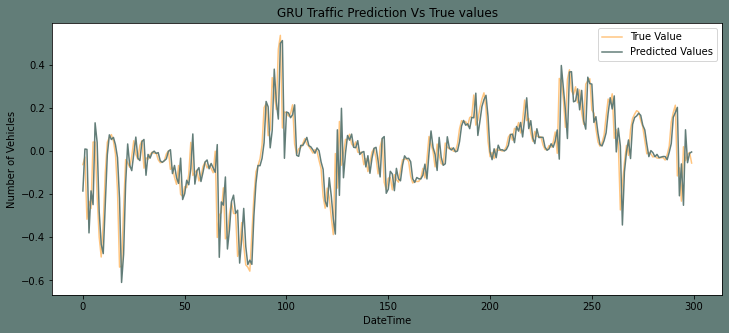

In [ ]:
#Results for J1 
RMSE_J1=RMSE_Value(y_testJ1,PredJ1)
PredictionsPlot(y_testJ1,PredJ1,0)

In [ ]:
# Functions to inverse transforms and Plot comparitive plots
# invert differenced forecast
def inverse_difference(last_ob, value):
    inversed = value + last_ob
    return inversed
#Plotting the comparison
def Sub_Plots2(df_1, df_2,title,m):
    fig, axes = plt.subplots(1, 2, figsize=(18,4), sharey=True,facecolor="#627D78")
    fig.suptitle(title)
    
    pl_1=sns.lineplot(ax=axes[0],data=df_1,color="darkorange")
    axes[0].set(ylabel ="Prediction")
    
    pl_2=sns.lineplot(ax=axes[1],data=df_2["10"],color="#627D78")
    axes[1].set(ylabel ="Orignal")

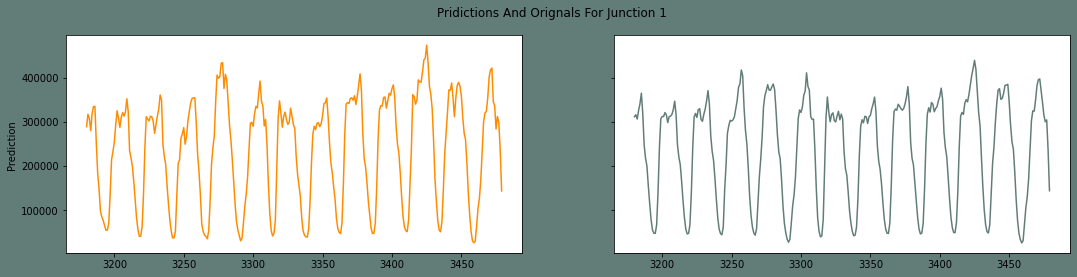

In [ ]:
# invert the differenced forecast for Junction 1 
recover1 = df_N1.Norm[-300:].to_frame()
recover1["Pred"]= PredJ1
Transform_reverssed_J1 = inverse_difference(recover1.Norm, recover1.Pred).to_frame()
Transform_reverssed_J1.columns = ["Pred_Normed"]
#Invert the normalizeation J1
Final_J1_Pred = (Transform_reverssed_J1.values* std_J1) + av_J1
Transform_reverssed_J1["Pred_Final"] =Final_J1_Pred
#Plotting the Predictions with orignals 
Sub_Plots2(Transform_reverssed_J1["Pred_Final"], df_10[-300:],"Pridictions And Orignals For Junction 1", 0)

In [ ]:
Transform_reverssed_J1

,Pred_Normed,Pred_Final
3180,0.465582,288843.656493
3181,0.697913,317076.413479
3182,0.616399,307170.867304
3183,0.389528,279601.591673
3184,0.710525,318608.932438
...,...,...
3475,0.423067,283677.197679
3476,0.656842,312085.392516
3477,0.538032,297647.756382
3478,0.027153,235565.935232
